In [1]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy import distance
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from uszipcode import SearchEngine

In [2]:
data_dir = os.getcwd() + '/yelp_dataset'

def load_dataset(data_dir, file):
    df = pd.DataFrame([])
    data_chunk = pd.read_json(os.path.join(data_dir, file), lines=True, chunksize=100000)
    for chunk in data_chunk:
          df = pd.concat([df, chunk])
    return df

print('Loading business data ...')
df_business = load_dataset(data_dir, 'business.json')
print('Loading checkin data ...')
df_checkin = load_dataset(data_dir, 'checkin.json')
print('Loading review data ...')
df_review = load_dataset(data_dir, 'review.json')

print('All datasets have been loaded!')

Loading business data ...
Loading checkin data ...
Loading review data ...
All datasets have been loaded!


In [9]:
df_business.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
3,"15655 W Roosevelt St, Ste 237",None,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ
4,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC


In [6]:
df_review.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg
2,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,2TzJjDVDEuAW6MR5Vuc1ug,5,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw
3,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg
4,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0,11a8sVPMUFtaC7_ABRkmtw,1,Today was my second out of three sessions I ha...,7,ssoyf2_x0EQMed6fgHeMyQ


In [7]:
df_checkin.head()

,business_id,date
0,--1UhMGODdWsrMastO9DZw,"2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016..."
1,--6MefnULPED_I942VcFNA,"2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012..."
2,--7zmmkVg-IMGaXbuVd0SQ,"2014-12-29 19:25:50, 2015-01-17 01:49:14, 2015..."
3,--8LPVSo5i0Oo61X01sV9A,2016-07-08 16:43:30
4,--9QQLMTbFzLJ_oT-ON3Xw,"2010-06-26 17:39:07, 2010-08-01 20:06:21, 2010..."


## Enrich features for businesses in US 

In [10]:
def enrich_business_features(df):
    """
    enrich business in the US with population, population density,
    land area and median household income by searching with zipcode
    """
    # list of US state abbreviations
    states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
              "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
              "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
              "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
              "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
    # keep only businesses in US
    df_business_us = df[df['state'].isin(states)]
    # get rid of missing zipcode items
    df_with_zipcode = df_business_us[~(df_business_us['postal_code']=='')] 
    # activate search search engine which would provide more features relate to zipcode
    search = SearchEngine(simple_zipcode=True)
    df_zipcode = pd.DataFrame()
    zipcode = df_with_zipcode['postal_code'].unique()
    df_zipcode['postal_code'] = zipcode
    # perform searching and enrich features
    df_zipcode['population'] = [search.by_zipcode(i).to_dict()['population'] for i in tqdm(zipcode)]
    df_zipcode['population_density'] = [search.by_zipcode(i).to_dict()['population_density'] for i in tqdm(zipcode)]
    df_zipcode['land_area_in_sqmi'] = [search.by_zipcode(i).to_dict()['land_area_in_sqmi'] for i in tqdm(zipcode)]
    df_zipcode['median_household_income'] = [search.by_zipcode(i).to_dict()['median_household_income'] for i in tqdm(zipcode)]
    # merge features to business dataframe
    df = df_business_us.merge(df_zipcode, how='left', on='postal_code').dropna()
    
    return df

df_business = enrich_business_features(df_business)

100%|██████████| 891/891 [00:00<00:00, 1401.89it/s]


## Extract review features and merge into business

In [4]:
def review_features(df):
    print('Extracting review features ...')
    # get total number of 'cool', 'funny' and 'useful'
    df_review_statistic = df.groupby('business_id')[['cool', 'funny', 'useful']].sum()
    # get average stars
    df_review_statistic['avg_stars_review'] = df.groupby('business_id')[['stars']].mean()
    # group review timestamps into a list
    df_review_statistic['date'] = df.groupby('business_id')['date'].apply(list)
    review_date = df_review_statistic['date'].values
    # get number of reviews
    df_review_statistic['review_count'] = [len(dates) for dates in review_date]
    # extract 1st and last review year and month
    review_start = [min(i) for i in review_date]
    review_latest = [max(i) for i in review_date]
    df_review_statistic['review_start_year'] = list(map(lambda x: x.year, review_start))
    df_review_statistic['review_start_month'] = list(map(lambda x: x.month, review_start))
    df_review_statistic['review_latest_year'] = list(map(lambda x: x.year, review_latest))
    df_review_statistic['review_latest_month'] = list(map(lambda x: x.month, review_latest))
    # get duration of review in years
    review_duration = np.array(review_latest) - np.array(review_start)
    print('Calculating business duration accoring to review time...')
    df_review_statistic['review_duration'] = [item/pd.Timedelta(days=365.25) for item in tqdm(review_duration)]
    # get review rate per month
    df_review_statistic['review_per_month'] = df_review_statistic['review_count']/df_review_statistic['review_duration']/12
    # drop redundant columns
    df_review_statistic.drop(columns=['date', 'review_count'], inplace=True)
    print('Review features extracted!')
    
    return df_review_statistic

df_review_statistic = review_features(df_review)
df_business = df_business.merge(df_review_statistic, on='business_id', how='inner')

Extracting review features ...


  4%|▎         | 6758/192606 [00:00<00:02, 67571.20it/s]

Calculating business duration accoring to review time...


100%|██████████| 192606/192606 [00:02<00:00, 71360.99it/s]


Review features extracted!


## Extract checkin featueas and merge into business

In [5]:
def checkin_features(df):
    print('Extracting checkin features...')
    checkin = df['date'].values
    checkin_split = list(map(lambda x: x.split(','), checkin))
    # extract 1st and last checkin time
    checkin_start = np.array([pd.Timestamp(i[0]) for i in checkin_split])
    checkin_stop = np.array([pd.Timestamp(i[-1]) for i in checkin_split])
    # get duration of checkin 
    checkin_duration = checkin_stop - checkin_start
    df['checkin_duration'] = [item/pd.Timedelta(days=365.25) for item in checkin_duration]
    # extract 1st and last checkin year and month
    df['checkin_start_year'] = list(map(lambda x: x.year, checkin_start))
    df['checkin_start_month'] = list(map(lambda x: x.month, checkin_start))
    df['checkin_latest_year'] = list(map(lambda x: x.year, checkin_stop))
    df['checkin_latest_month'] = list(map(lambda x: x.month, checkin_stop))
    # get number of checkins
    df['checkin_count'] = list(map(lambda x: len(x), checkin_split))
    # calculate checkins per month
    df['checkin_per_month'] = df['checkin_count']/df['checkin_duration']/12
    df.drop(columns=['date'], inplace=True)
    print('Checkin features have been extracted!')
    
    return df

df_checkin = checkin_features(df_checkin)
df_business = df_business.merge(df_checkin, on='business_id', how='inner')

Extracting checkin features...
Checkin features have been extracted!


## Cluster business with Geo-coordinates

In [58]:
def business_clustering(df):
    print("Clustering business according to Geo-coordinates ...")
    """
    DBSCAN - Density-Based Spatial Clustering of Applications with Noise
    """
    coords = df[['latitude', 'longitude']].values
    # radius of the earth in km
    kms_per_radian = 6371
    # the minimus distance between two restruants is 20m
    epsilon = .05 / kms_per_radian
    # perform clustering
    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
    print('Number of clusters: {}'.format(num_clusters))
    df['coords_cluster_label'] = cluster_labels
    # number of business in each cluster
    counts_cluster = [len(cluster) for cluster in clusters]
    df['neighbors'] = [counts_cluster[i] for i in cluster_labels]
    # if the number of neighbors > 20, the business in a chain
    df['is_chain'] = df['neighbors'] >=5
    df['is_chain'] = df_business['is_chain'].astype(int)
    
    return df

df_business = business_clustering(df_business)
df_business.to_pickle(os.path.join(data_dir, 'features.pkl'))

Clustering business according to Geo-coordinates ...
Number of clusters: 42710


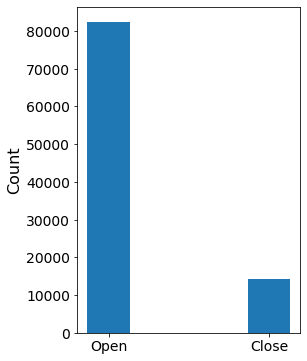

In [98]:
open = len(df_business[df_business['is_open']==1])
close = len(df_business[df_business['is_open']==0])
fig, ax = plt.subplots(figsize=(4,6))
plt.bar([0.5,0.8], [open, close], width=0.08)
plt.xticks([0.5,0.8], ('Open', 'Close'))
ax.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('Count', fontsize=16)
plt.savefig('./report/open_close_count.png', bbox_inches='tight', dpi=300)
plt.show()

In [97]:
close/(open+close)

0.1481082871098601

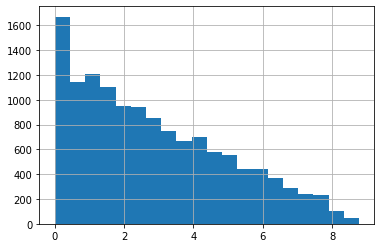

In [13]:
df_business[df_business['is_open']==0]['checkin_duration'].hist(bins=20)
plt.show()

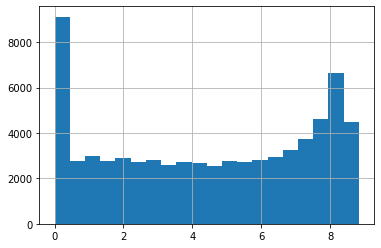

In [14]:
df_business[df_business['is_open']==1]['checkin_duration'].hist(bins=20)
plt.show()

In [17]:
df_business.iloc[0]

address                                            10110 Johnston Rd, Ste 15
attributes                 {'GoodForKids': 'True', 'NoiseLevel': 'u'avera...
business_id                                           gnKjwL_1w79qoiV3IC_xQQ
categories                                 Sushi Bars, Restaurants, Japanese
city                                                               Charlotte
hours                      {'Monday': '17:30-21:30', 'Wednesday': '17:30-...
is_open                                                                    1
latitude                                                             35.0926
longitude                                                           -80.8591
name                                             Musashi Japanese Restaurant
postal_code                                                            28210
review_count_x                                                           170
stars                                                                      4

In [ ]:
# text idea to group business
# https://www.kaggle.com/ksjpswaroop/yelp-data-analysis